### Data Cleaning and Analysis on German, Berlin AirBnB listings

In this project, we'll work with AirBnB listings data from Germany, Berlin.<br>
We will pursue the following steps:
1. Set an original data science use case/question (You can investigate the data from the perspective of a listings owner, customer or Airbnb stuff etc. It depends on what you want to explore and find out in the data)
2. Prepare the data based on your case/question
3. Analyse and explore your data 
4. Create a presentation of your work and submit it along with your code in Jupyter notebook.

In [1]:
# Import of necessary packages
import numpy as np
import pandas as pd
import csv
import sqlite3
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Setting a variable with all csv-files
airbnb_files = glob(r'*.csv')
airbnb_files

['airbnb_locations_tableau_export.csv',
 'a_listings_summary.csv',
 'calendar_summary.csv',
 'listings.csv',
 'neighbourhoods.csv',
 'reviews.csv',
 'reviews_summary.csv']

In [3]:
# Creating a new database:
database_path = 'AirBnB_Berlin_Listing_Database.db'

# Loading the .csvs into the sqlite database
with sqlite3.connect(database_path) as db:
    for f in airbnb_files:
        print(f)
        df = pd.read_csv(f)#.sample(frac=0.05)
        df.to_sql(os.path.basename(f).split('.')[0], db, if_exists='replace')

airbnb_locations_tableau_export.csv
a_listings_summary.csv
calendar_summary.csv
listings.csv
neighbourhoods.csv
reviews.csv
reviews_summary.csv


In [4]:
# Checking if the tables have been loaded

with sqlite3.connect(database_path) as db:
    c = db.cursor()
    c.execute("SELECT name FROM sqlite_master WHERE type='table';")
    
    print('The following tables exist in the DB:')
    for i, tab in enumerate(c.fetchall(), 1):
        print(i, '. ', tab[0], sep='')


The following tables exist in the DB:
1. airbnb_locations_tableau_export
2. a_listings_summary
3. calendar_summary
4. listings
5. neighbourhoods
6. reviews
7. reviews_summary


In [5]:
# @Nemanjar: At the moment I have to rename the file with the most columns so that it is the first one to be read in (alphabetical, atm). How can I make this code independent from it?

# Creating a dataframe to compare all csv's and their columns
df_0 = pd.DataFrame()
column_list = []
j = 0
for i in airbnb_files:
    j += 1
    filename = airbnb_files[j-1]
    print(filename)
    
    column = pd.read_csv(airbnb_files[j-1], encoding='Latin-1', nrows = 0)
    print(column,"\n")
    for k in column:
        column_list.append(k)
    column_series = pd.Series(column_list)
    df_0[filename] = column_series
    column_list = []

    

airbnb_locations_tableau_export.csv
Empty DataFrame
Columns: [id;neighbourhood;neighbourhood_group_cleansed;review_scores_rating;review_scores_location;latitude;longitude;number_of_reviews]
Index: [] 

a_listings_summary.csv
Empty DataFrame
Columns: [id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type,

In [6]:
# Let's check the first entries of comparing the column names of all tables
df_0.head(25)

,airbnb_locations_tableau_export.csv,a_listings_summary.csv,calendar_summary.csv,listings.csv,neighbourhoods.csv,reviews.csv,reviews_summary.csv
0,id;neighbourhood;neighbourhood_group_cleansed;...,id,listing_id,id,neighbourhood_group,listing_id,listing_id


In [7]:
# Idea generation:

# Check Satisfaction Scores for different neighborhoods
# Dig down in Mitte and split in smaller units to see differences

In [8]:
# Lets frist create a quick function to show SQLs:
def run_query(q):

    with sqlite3.connect(database_path) as db:
        df = pd.read_sql(q, db)

    return df

-----
### Rating correlation in regards of districts ("neighbourhood_group_cleansed") for Mitte and its sublocations

#### Underlying question / use case: As a customer, how well can I rely on the Berlin location filter in order to find a nice (well-rated) stay?

In [9]:
df = run_query(
    """
    SELECT COUNT(DISTINCT id) AS "Count of unique listings", neighbourhood_group_cleansed
    FROM a_listings_summary
    GROUP BY neighbourhood_group_cleansed
    ORDER BY "Count of unique listings" DESC
    """
)

In [10]:
df

,Count of unique listings,neighbourhood_group_cleansed
0,5497,Friedrichshain-Kreuzberg
1,4631,Mitte
2,3541,Pankow
3,3499,Neukölln
4,1592,Charlottenburg-Wilm.
5,1560,Tempelhof - Schöneberg
6,688,Lichtenberg
7,595,Treptow - Köpenick
8,437,Steglitz - Zehlendorf
9,247,Reinickendorf


In [11]:
df = run_query(
    """
    SELECT id, neighbourhood,neighbourhood_group_cleansed, review_scores_rating, review_scores_location
    FROM a_listings_summary
    WHERE neighbourhood_group_cleansed == "Mitte"
    """
)

In [12]:
df["neighbourhood"].unique()

array(['Mitte', 'Moabit', None, 'Wedding', 'Tiergarten', 'Hansaviertel',
       'Potsdamer Platz', 'Friedrichshain', 'Schöneberg'], dtype=object)

In [13]:
df.head()

,id,neighbourhood,neighbourhood_group_cleansed,review_scores_rating,review_scores_location
0,2015,Mitte,Mitte,93.0,10.0
1,22677,Mitte,Mitte,94.0,10.0
2,33043,Moabit,Mitte,89.0,9.0
3,37052,Mitte,Mitte,95.0,10.0
4,46172,Mitte,Mitte,98.0,10.0


In [14]:
df.describe()

,id,review_scores_rating,review_scores_location
count,4.631000e+03,3737.000000,3727.000000
mean,1.605552e+07,93.757560,9.475986
std,8.438834e+06,7.928791,0.787994
min,2.015000e+03,20.000000,2.000000
25%,8.816872e+06,91.000000,9.000000
50%,1.725383e+07,96.000000,10.000000
75%,2.274860e+07,100.000000,10.000000
max,2.986680e+07,100.000000,10.000000


In [15]:
df[df["neighbourhood_group_cleansed"]=="Mitte"]["neighbourhood"].unique()

array(['Mitte', 'Moabit', None, 'Wedding', 'Tiergarten', 'Hansaviertel',
       'Potsdamer Platz', 'Friedrichshain', 'Schöneberg'], dtype=object)

In [16]:
mitte_mean = df[df["neighbourhood"]=="Mitte"]["review_scores_location"].mean()
moabit_mean = df[df["neighbourhood"]=="Moabit"]["review_scores_location"].mean()
wedding_mean = df[df["neighbourhood"]=="Wedding"]["review_scores_location"].mean()
gesundbrunnen_mean = df[df["neighbourhood"]=="Wedding"]["review_scores_location"].mean()
hansaviertel_mean = df[df["neighbourhood"]=="Hansaviertel"]["review_scores_location"].mean()
potsdamer_mean = df[df["neighbourhood"]=="Potsdamer Platz"]["review_scores_location"].mean()
fhain_mean = df[df["neighbourhood"]=="Friedrichshain"]["review_scores_location"].mean()
schöneberg_mean = df[df["neighbourhood"]=="Schöneberg"]["review_scores_location"].mean()

mitte_overall_mean = df[df["neighbourhood_group_cleansed"]=="Mitte"]["review_scores_location"].mean()


In [17]:
print(moabit_mean)
print(wedding_mean)
print(gesundbrunnen_mean)
print(mitte_mean)
print(potsdamer_mean)
print(fhain_mean)
print(schöneberg_mean)

print("Overall mean location rating:",mitte_overall_mean)

9.262642740619903
9.094424460431656
9.094424460431656
9.82286432160804
9.970588235294118
10.0
10.0
Overall mean location rating: 9.475986047759593


In [18]:
# Let's check a correlation matrix within the district of Mitte

# quick function to convert text/string columns to categories
def convert_cat_2_num(df):
    """convert the columns of a DataFrame into category type"""
    temp_df = pd.DataFrame()

    for column in df.columns:
        temp_df[column] = df[column].astype("category").cat.codes
    return temp_df

In [19]:
df_converted = convert_cat_2_num(df[["id","neighbourhood","review_scores_rating","review_scores_location"]])

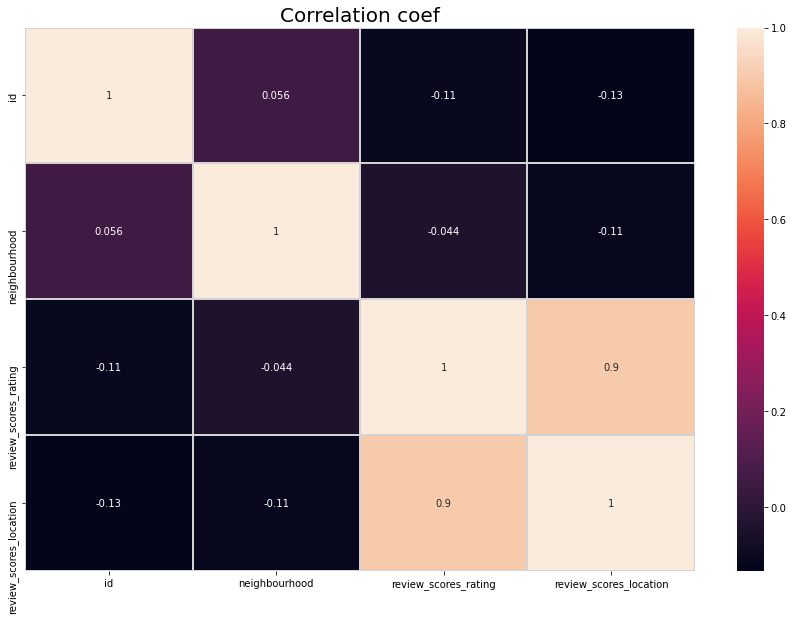

In [20]:
plt.figure(figsize=(15,10))
corr = df_converted[df_converted.columns].corr()
plt.title("Correlation coef", fontsize=20)
sns.heatmap(corr,annot=True, linecolor="lightgrey", linewidth=1);

-----
### Satisfaction rates in realtion to booking dates (season bias)

#### Underlying question / use case: As AirBnB-Staff, how much do rating varies depending on the season?

In [21]:
df = run_query(
    """
    SELECT id, neighbourhood_group_cleansed,neighbourhood, review_scores_rating, review_scores_location, date, available, b.price
    FROM a_listings_summary AS a
    LEFT JOIN calendar_summary AS b
        ON a.id = b.listing_id
    WHERE neighbourhood_group_cleansed == "Mitte"
        AND available == "t"
    """
)

In [22]:
df[df["available"] == "t"].head(25)

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price
0,2015,Mitte,Mitte,93.0,10.0,2018-12-16,t,$76.00
1,2015,Mitte,Mitte,93.0,10.0,2018-12-17,t,$76.00
2,2015,Mitte,Mitte,93.0,10.0,2018-12-18,t,$76.00
3,2015,Mitte,Mitte,93.0,10.0,2018-12-19,t,$76.00
4,2015,Mitte,Mitte,93.0,10.0,2018-12-20,t,$76.00
5,2015,Mitte,Mitte,93.0,10.0,2018-12-21,t,$76.00
6,2015,Mitte,Mitte,93.0,10.0,2018-12-22,t,$76.00
7,2015,Mitte,Mitte,93.0,10.0,2018-12-23,t,$76.00
8,2015,Mitte,Mitte,93.0,10.0,2018-12-24,t,$76.00
9,2015,Mitte,Mitte,93.0,10.0,2018-12-25,t,$76.00


In [23]:
df['date'] = pd.to_datetime(df['date'])
type(df["date"].min())

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
df.sample(25)

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price
3094,139769,Mitte,None,96.0,10.0,2019-02-07,t,$65.00
384734,29321983,Mitte,Mitte,100.0,10.0,2018-12-08,t,$100.00
294333,23443453,Mitte,Wedding,96.0,8.0,2019-08-08,t,$35.00
266508,21493992,Mitte,Wedding,86.0,9.0,2019-01-13,t,$68.00
360324,28020281,Mitte,Mitte,85.0,10.0,2019-07-03,t,$70.00
50668,2328948,Mitte,Moabit,91.0,9.0,2019-10-22,t,$69.00
339918,26970086,Mitte,Mitte,91.0,10.0,2019-10-23,t,$79.00
327323,26104495,Mitte,Mitte,80.0,9.0,2019-08-30,t,$120.00
338897,26967136,Mitte,Mitte,96.0,10.0,2019-05-25,t,$98.00
809,46172,Mitte,Mitte,98.0,10.0,2019-04-29,t,$48.00


In [25]:
# Alist = [df["id"]=="1692136"]
# Alist = df["season"]
# np.unique(Alist)

In [26]:
# df.drop(columns="season", inplace = True)
# df.drop(columns="id_copy", inplace = True)

In [27]:
# Lets create extra columns for the booked season per listing id
df["winter"] = np.nan
df["spring"] = np.nan
df["summer"] = np.nan
df["autumn"] = np.nan

In [28]:
df["winter"] = np.where(df["date"] <= pd.Timestamp('2019-03-20 00:00:00'),1,np.nan)
df["spring"] = np.where((df["date"] > pd.Timestamp('2019-03-20 00:00:00')) & (df["date"] <= pd.Timestamp('2019-06-21 00:00:00')),1,np.nan)
df["summer"] = np.where((df["date"] > pd.Timestamp('2019-06-21 00:00:00')) & (df["date"] <= pd.Timestamp('2019-09-23 00:00:00')),1,np.nan)
df["autumn"] = np.where(df["date"] > pd.Timestamp('2019-09-23 00:00:00'),1,np.nan)
# df["id_copy"] = df["id"]
# df.set_index('id_copy', inplace = True)
df.reset_index(inplace=True,drop=True)
df.sample(25)

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price,winter,spring,summer,autumn
163974,13489704,Mitte,Mitte,97.0,10.0,2019-06-29,t,$90.00,NaN,NaN,1.0,NaN
349690,27428289,Mitte,Moabit,85.0,9.0,2019-08-03,t,$65.00,NaN,NaN,1.0,NaN
109104,7831357,Mitte,Mitte,99.0,10.0,2019-04-03,t,$100.00,NaN,1.0,NaN,NaN
216730,17134678,Mitte,Mitte,97.0,10.0,2019-02-26,t,$109.00,1.0,NaN,NaN,NaN
358395,27997640,Mitte,Mitte,NaN,NaN,2019-07-21,t,$104.00,NaN,NaN,1.0,NaN
377989,29001953,Mitte,Mitte,100.0,10.0,2019-01-27,t,$39.00,1.0,NaN,NaN,NaN
130,2015,Mitte,Mitte,93.0,10.0,2019-04-25,t,$77.00,NaN,1.0,NaN,NaN
214702,16972536,Mitte,None,NaN,NaN,2019-05-30,t,$32.00,NaN,1.0,NaN,NaN
363890,28118883,Mitte,Mitte,90.0,10.0,2019-01-15,t,$89.00,1.0,NaN,NaN,NaN
165902,13582166,Mitte,Mitte,91.0,10.0,2019-09-02,t,$240.00,NaN,NaN,1.0,NaN


In [29]:
df["winter_count"] = np.nan
df["spring_count"] = np.nan
df["summer_count"] = np.nan
df["autumn_count"] = np.nan


pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    for ids in df["id"].unique():
        winter_count = df["winter"][df["id"]==ids].count()
        df["winter_count"][df["id"]==ids] = winter_count

        spring_count = df["spring"][df["id"]==ids].count()
        df["spring_count"][df["id"]==ids] = spring_count

        summer_count = df["summer"][df["id"]==ids].count()
        df["summer_count"][df["id"]==ids] = summer_count

        autumn_count = df["autumn"][df["id"]==ids].count()
        df["autumn_count"][df["id"]==ids] = autumn_count

        # resetting counters 
        winter_count = 0
        spring_count = 0
        summer_count = 0
        autumn_count = 0

In [30]:
df.sample(25)

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price,winter,spring,summer,autumn,winter_count,spring_count,summer_count,autumn_count
152360,12505608,Mitte,Mitte,92.0,10.0,2019-09-23,t,$260.00,NaN,NaN,1.0,NaN,100.0,90.0,94.0,44.0
209479,16479631,Mitte,Mitte,93.0,10.0,2019-05-27,t,$115.00,NaN,1.0,NaN,NaN,69.0,53.0,78.0,44.0
359689,28004334,Mitte,Mitte,NaN,NaN,2019-08-05,t,$99.00,NaN,NaN,1.0,NaN,121.0,93.0,94.0,8.0
202227,16028905,Mitte,Wedding,99.0,10.0,2018-12-16,t,$40.00,1.0,NaN,NaN,NaN,76.0,0.0,0.0,0.0
379817,29069957,Mitte,Wedding,100.0,9.0,2019-05-29,t,$29.00,NaN,1.0,NaN,NaN,50.0,93.0,94.0,44.0
362668,28066374,Mitte,Mitte,NaN,NaN,2019-10-18,t,$143.00,NaN,NaN,NaN,1.0,131.0,93.0,94.0,44.0
304974,24351666,Mitte,Moabit,99.0,10.0,2019-01-19,t,$60.00,1.0,NaN,NaN,NaN,119.0,57.0,54.0,44.0
211582,16674988,Mitte,Wedding,84.0,7.0,2019-04-11,t,$21.00,NaN,1.0,NaN,NaN,103.0,93.0,88.0,44.0
101974,6846819,Mitte,Moabit,95.0,9.0,2019-01-20,t,$60.00,1.0,NaN,NaN,NaN,82.0,0.0,0.0,0.0
366169,28269961,Mitte,Mitte,NaN,NaN,2018-11-18,t,$59.00,1.0,NaN,NaN,NaN,39.0,0.0,0.0,0.0


In [31]:
# Now lets check which listing is booked the most in which season and compare the ratings

# First get an overview of the ratings
pd.pivot_table(df,index = ["neighbourhood","neighbourhood_group_cleansed"], values = ["review_scores_rating","review_scores_location"] , aggfunc='mean')

,,review_scores_location,review_scores_rating
neighbourhood,neighbourhood_group_cleansed,,
Friedrichshain,Mitte,10.000000,96.000000
Hansaviertel,Mitte,9.683162,93.334037
Mitte,Mitte,9.802749,93.229526
Moabit,Mitte,9.227395,93.093453
Potsdamer Platz,Mitte,10.000000,96.202571
Schöneberg,Mitte,10.000000,94.000000
Tiergarten,Mitte,9.269329,91.330206
Wedding,Mitte,9.061184,91.813146


In [32]:
# Let's reduce the dataset so we dont have the duplicates (due to the booking-merging)
df_reduced = df.drop_duplicates(subset=['id'])
df_reduced = df_reduced.drop(["winter","spring","summer","autumn"], axis=1)
df_reduced

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price,winter_count,spring_count,summer_count,autumn_count
0,2015,Mitte,Mitte,93.0,10.0,2018-12-16,t,$76.00,95.0,46.0,0.0,0.0
141,22677,Mitte,Mitte,94.0,10.0,2018-11-07,t,$100.00,92.0,93.0,43.0,0.0
369,33043,Mitte,Moabit,89.0,9.0,2018-11-07,t,$60.00,115.0,90.0,94.0,44.0
712,37052,Mitte,Mitte,95.0,10.0,2018-12-09,t,$50.00,25.0,0.0,0.0,0.0
737,46172,Mitte,Mitte,98.0,10.0,2019-02-16,t,$48.00,33.0,93.0,94.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...
393867,29824905,Mitte,Mitte,NaN,NaN,2018-11-13,t,$34.00,9.0,2.0,0.0,0.0
393878,29829280,Mitte,Mitte,NaN,NaN,2018-11-12,t,$53.00,14.0,0.0,0.0,0.0
393892,29848269,Mitte,Mitte,NaN,NaN,2018-11-14,t,$90.00,31.0,0.0,0.0,0.0
393923,29856708,Mitte,Mitte,NaN,NaN,2018-11-07,t,$60.00,83.0,93.0,94.0,44.0


In [33]:
df_reduced["peak_season"] = np.nan
df_reduced["peak_season_count"] = df_reduced[["winter_count","spring_count","summer_count","autumn_count"]].max(axis=1)

# pd.reset_option('mode.chained_assignment')
# with pd.option_context('mode.chained_assignment', None):
#     for ids in df_reduced["id"]:
#         peak_count = df_reduced["peak_season_count"][df["id"]==ids]
        
#         if peak_count == df_reduced["winter_count"][df["id"]==ids]:
#             df_reduced["peak_season"][df["id"]==ids] = "winter"
#         elif peak_count == df_reduced["spring_count"][df["id"]==ids]:
#             df_reduced["peak_season"][df["id"]==ids] = "spring"
#         elif peak_count == df_reduced["summer_count"][df["id"]==ids]:
#             df_reduced["peak_season"][df["id"]==ids] = "summer"
#         elif peak_count == df_reduced["autumn_count"][df["id"]==ids]:
#             df_reduced["peak_season"][df["id"]==ids] = "autumn"

df_reduced
    

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price,winter_count,spring_count,summer_count,autumn_count,peak_season,peak_season_count
0,2015,Mitte,Mitte,93.0,10.0,2018-12-16,t,$76.00,95.0,46.0,0.0,0.0,NaN,95.0
141,22677,Mitte,Mitte,94.0,10.0,2018-11-07,t,$100.00,92.0,93.0,43.0,0.0,NaN,93.0
369,33043,Mitte,Moabit,89.0,9.0,2018-11-07,t,$60.00,115.0,90.0,94.0,44.0,NaN,115.0
712,37052,Mitte,Mitte,95.0,10.0,2018-12-09,t,$50.00,25.0,0.0,0.0,0.0,NaN,25.0
737,46172,Mitte,Mitte,98.0,10.0,2019-02-16,t,$48.00,33.0,93.0,94.0,44.0,NaN,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393867,29824905,Mitte,Mitte,NaN,NaN,2018-11-13,t,$34.00,9.0,2.0,0.0,0.0,NaN,9.0
393878,29829280,Mitte,Mitte,NaN,NaN,2018-11-12,t,$53.00,14.0,0.0,0.0,0.0,NaN,14.0
393892,29848269,Mitte,Mitte,NaN,NaN,2018-11-14,t,$90.00,31.0,0.0,0.0,0.0,NaN,31.0
393923,29856708,Mitte,Mitte,NaN,NaN,2018-11-07,t,$60.00,83.0,93.0,94.0,44.0,NaN,94.0


In [34]:
# Writing down the peak season

# @Nemanjar: I'm very curious on how to do this in a nicer way, since this nested command is definitaley not the best way, even if it works ;-)
df_reduced["peak_season"] = np.where(df_reduced["peak_season_count"] == df_reduced["winter_count"],"Winter",np.where(df_reduced["peak_season_count"] == df_reduced["spring_count"],"Spring",np.where(df_reduced["peak_season_count"] == df_reduced["summer_count"],"Summer",np.where(df_reduced["peak_season_count"] == df_reduced["autumn_count"],"Autumn","Other"))))

In [35]:
df_reduced

,id,neighbourhood_group_cleansed,neighbourhood,review_scores_rating,review_scores_location,date,available,price,winter_count,spring_count,summer_count,autumn_count,peak_season,peak_season_count
0,2015,Mitte,Mitte,93.0,10.0,2018-12-16,t,$76.00,95.0,46.0,0.0,0.0,Winter,95.0
141,22677,Mitte,Mitte,94.0,10.0,2018-11-07,t,$100.00,92.0,93.0,43.0,0.0,Spring,93.0
369,33043,Mitte,Moabit,89.0,9.0,2018-11-07,t,$60.00,115.0,90.0,94.0,44.0,Winter,115.0
712,37052,Mitte,Mitte,95.0,10.0,2018-12-09,t,$50.00,25.0,0.0,0.0,0.0,Winter,25.0
737,46172,Mitte,Mitte,98.0,10.0,2019-02-16,t,$48.00,33.0,93.0,94.0,44.0,Summer,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393867,29824905,Mitte,Mitte,NaN,NaN,2018-11-13,t,$34.00,9.0,2.0,0.0,0.0,Winter,9.0
393878,29829280,Mitte,Mitte,NaN,NaN,2018-11-12,t,$53.00,14.0,0.0,0.0,0.0,Winter,14.0
393892,29848269,Mitte,Mitte,NaN,NaN,2018-11-14,t,$90.00,31.0,0.0,0.0,0.0,Winter,31.0
393923,29856708,Mitte,Mitte,NaN,NaN,2018-11-07,t,$60.00,83.0,93.0,94.0,44.0,Summer,94.0


In [36]:
pd.pivot_table(df_reduced,index = ["peak_season"], values = ["review_scores_rating"] , aggfunc='mean')

,review_scores_rating
peak_season,
Autumn,93.812500
Spring,94.834783
Summer,93.248869
Winter,93.807545


In [37]:
# After all, there is no clear season bias noticable. There is only slightly better ratings during spring times

-----
### Local distribution

#### Underlying question / use case: How are the listing distributed over the area?

In [38]:
df = run_query(
    """
    SELECT id, neighbourhood, neighbourhood_group_cleansed, review_scores_rating, review_scores_location, latitude, longitude, number_of_reviews
    FROM a_listings_summary
    """
)
df

,id,neighbourhood,neighbourhood_group_cleansed,review_scores_rating,review_scores_location,latitude,longitude,number_of_reviews
0,2015,Mitte,Mitte,93.0,10.0,52.534537,13.402557,118
1,2695,None,Pankow,100.0,10.0,52.548513,13.404553,6
2,3176,Prenzlauer Berg,Pankow,92.0,10.0,52.534996,13.417579,143
3,3309,Schöneberg,Tempelhof - Schöneberg,88.0,9.0,52.498855,13.349065,25
4,7071,Prenzlauer Berg,Pankow,96.0,10.0,52.543157,13.415091,197
...,...,...,...,...,...,...,...,...
22547,29856708,Mitte,Mitte,NaN,NaN,52.533865,13.400731,0
22548,29857108,Schöneberg,Tempelhof - Schöneberg,NaN,NaN,52.496211,13.341738,0
22549,29864272,Prenzlauer Berg,Pankow,NaN,NaN,52.531800,13.411999,0
22550,29866805,Mitte,Mitte,NaN,NaN,52.520802,13.378688,0


In [39]:
# Lets check the statistical values to spot potential outliers (as done for all others)
df["number_of_reviews"].describe()

count    22552.000000
mean        17.840679
std         36.769624
min          0.000000
25%          1.000000
50%          5.000000
75%         16.000000
max        498.000000
Name: number_of_reviews, dtype: float64

In [40]:
df.describe()
# No outliers, no anomalities

,id,review_scores_rating,review_scores_location,latitude,longitude,number_of_reviews
count,2.255200e+04,18163.000000,18121.000000,22552.000000,22552.000000,22552.000000
mean,1.571560e+07,94.413863,9.505491,52.509824,13.406107,17.840679
std,8.552069e+06,7.639644,0.762161,0.030825,0.057964,36.769624
min,2.015000e+03,20.000000,2.000000,52.345803,13.103557,0.000000
25%,8.065954e+06,92.000000,9.000000,52.489065,13.375411,1.000000
50%,1.686638e+07,97.000000,10.000000,52.509079,13.416779,5.000000
75%,2.258393e+07,100.000000,10.000000,52.532669,13.439259,16.000000
max,2.986735e+07,100.000000,10.000000,52.651670,13.757642,498.000000


In [41]:
df["neighbourhood"].unique()
# no spelling mistakes or irregularities

array(['Mitte', None, 'Prenzlauer Berg', 'Schöneberg', 'Friedrichshain',
       'Kreuzberg', 'Neukölln', 'Moabit', 'Charlottenburg', 'Alt-Treptow',
       'Lichterfelde', 'Schmöckwitz', 'Schmargendorf',
       'Niederschönhausen', 'Friedrichshagen', 'Wilmersdorf',
       'Heinersdorf', 'Rummelsburg', 'Friedenau', 'Wedding',
       'Reinickendorf', 'Pankow', 'Tegel', 'Buckow', 'Karlshorst',
       'Lichtenberg', 'Zehlendorf', 'Tiergarten', 'Rudow', 'Altglienicke',
       'Hansaviertel', 'Lichtenrade', 'Westend', 'Mahlsdorf',
       'Potsdamer Platz', 'Biesdorf', 'Wannsee', 'Johannisthal',
       'Konradshöhe', 'Marienfelde', 'Wilhelmstadt', 'Baumschulenweg',
       'Halensee', 'Steglitz', 'Frohnau', 'Nikolassee', 'Karow',
       'Wittenau', 'Tempelhof', 'Rahnsdorf', 'Kladow', 'Lankwitz',
       'Alt-Hohenschönhausen', 'Weißensee', 'Rosenthal', 'Gropiusstadt',
       'Britz', 'Kaulsdorf', 'Hellersdorf', 'Marzahn',
       'Märkisches Viertel', 'Dahlem', 'Adlershof', 'Wilhelmsruh',
       

In [42]:
df.to_csv(r'airbnb_locations_tableau_export.csv', index = False, sep =';')

In [43]:
#second import of packages for location visualization
import descartes
from shapely.geometry import Point, Polygon
import gpxpy
import gpxpy.gpx
import folium
import sys
import geopandas as gpd

%matplotlib inline

In [44]:
# Since installation of geopandas was a massive struggle, this command can help see if it was successfull
'geopandas' in sys.modules

True

In [66]:
# Let's import the street map of Berlin
street_map = gpd.read_file("Berlin_Bezirke.shp")
street_map = gpd.read_file("gis_osm_buildings_a_free_1.shp")

In [67]:
# Information about the coordinate system
street_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [68]:
# Information about the boundaries of the map (for each polygon)
street_map.bounds

,minx,miny,maxx,maxy
0,13.302773,52.519572,13.303323,52.519635
1,13.352638,52.533221,13.353535,52.533684
2,13.353727,52.522951,13.353973,52.523043
3,13.355055,52.526964,13.355656,52.527522
4,13.359868,52.531519,13.360409,52.531922
...,...,...,...,...
507803,13.355948,52.593342,13.356084,52.593410
507804,13.353781,52.593576,13.353947,52.593678
507805,13.357286,52.591578,13.357608,52.591728
507806,13.357338,52.591444,13.357663,52.591596


In [71]:
# Designate coordinate system
crs = {"init":"espc:4326"}
gdf = street_map.set_crs('epsg:4326', allow_override=True)
       
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df["longitude"],df["latitude"])]
       
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, geometry = geometry)

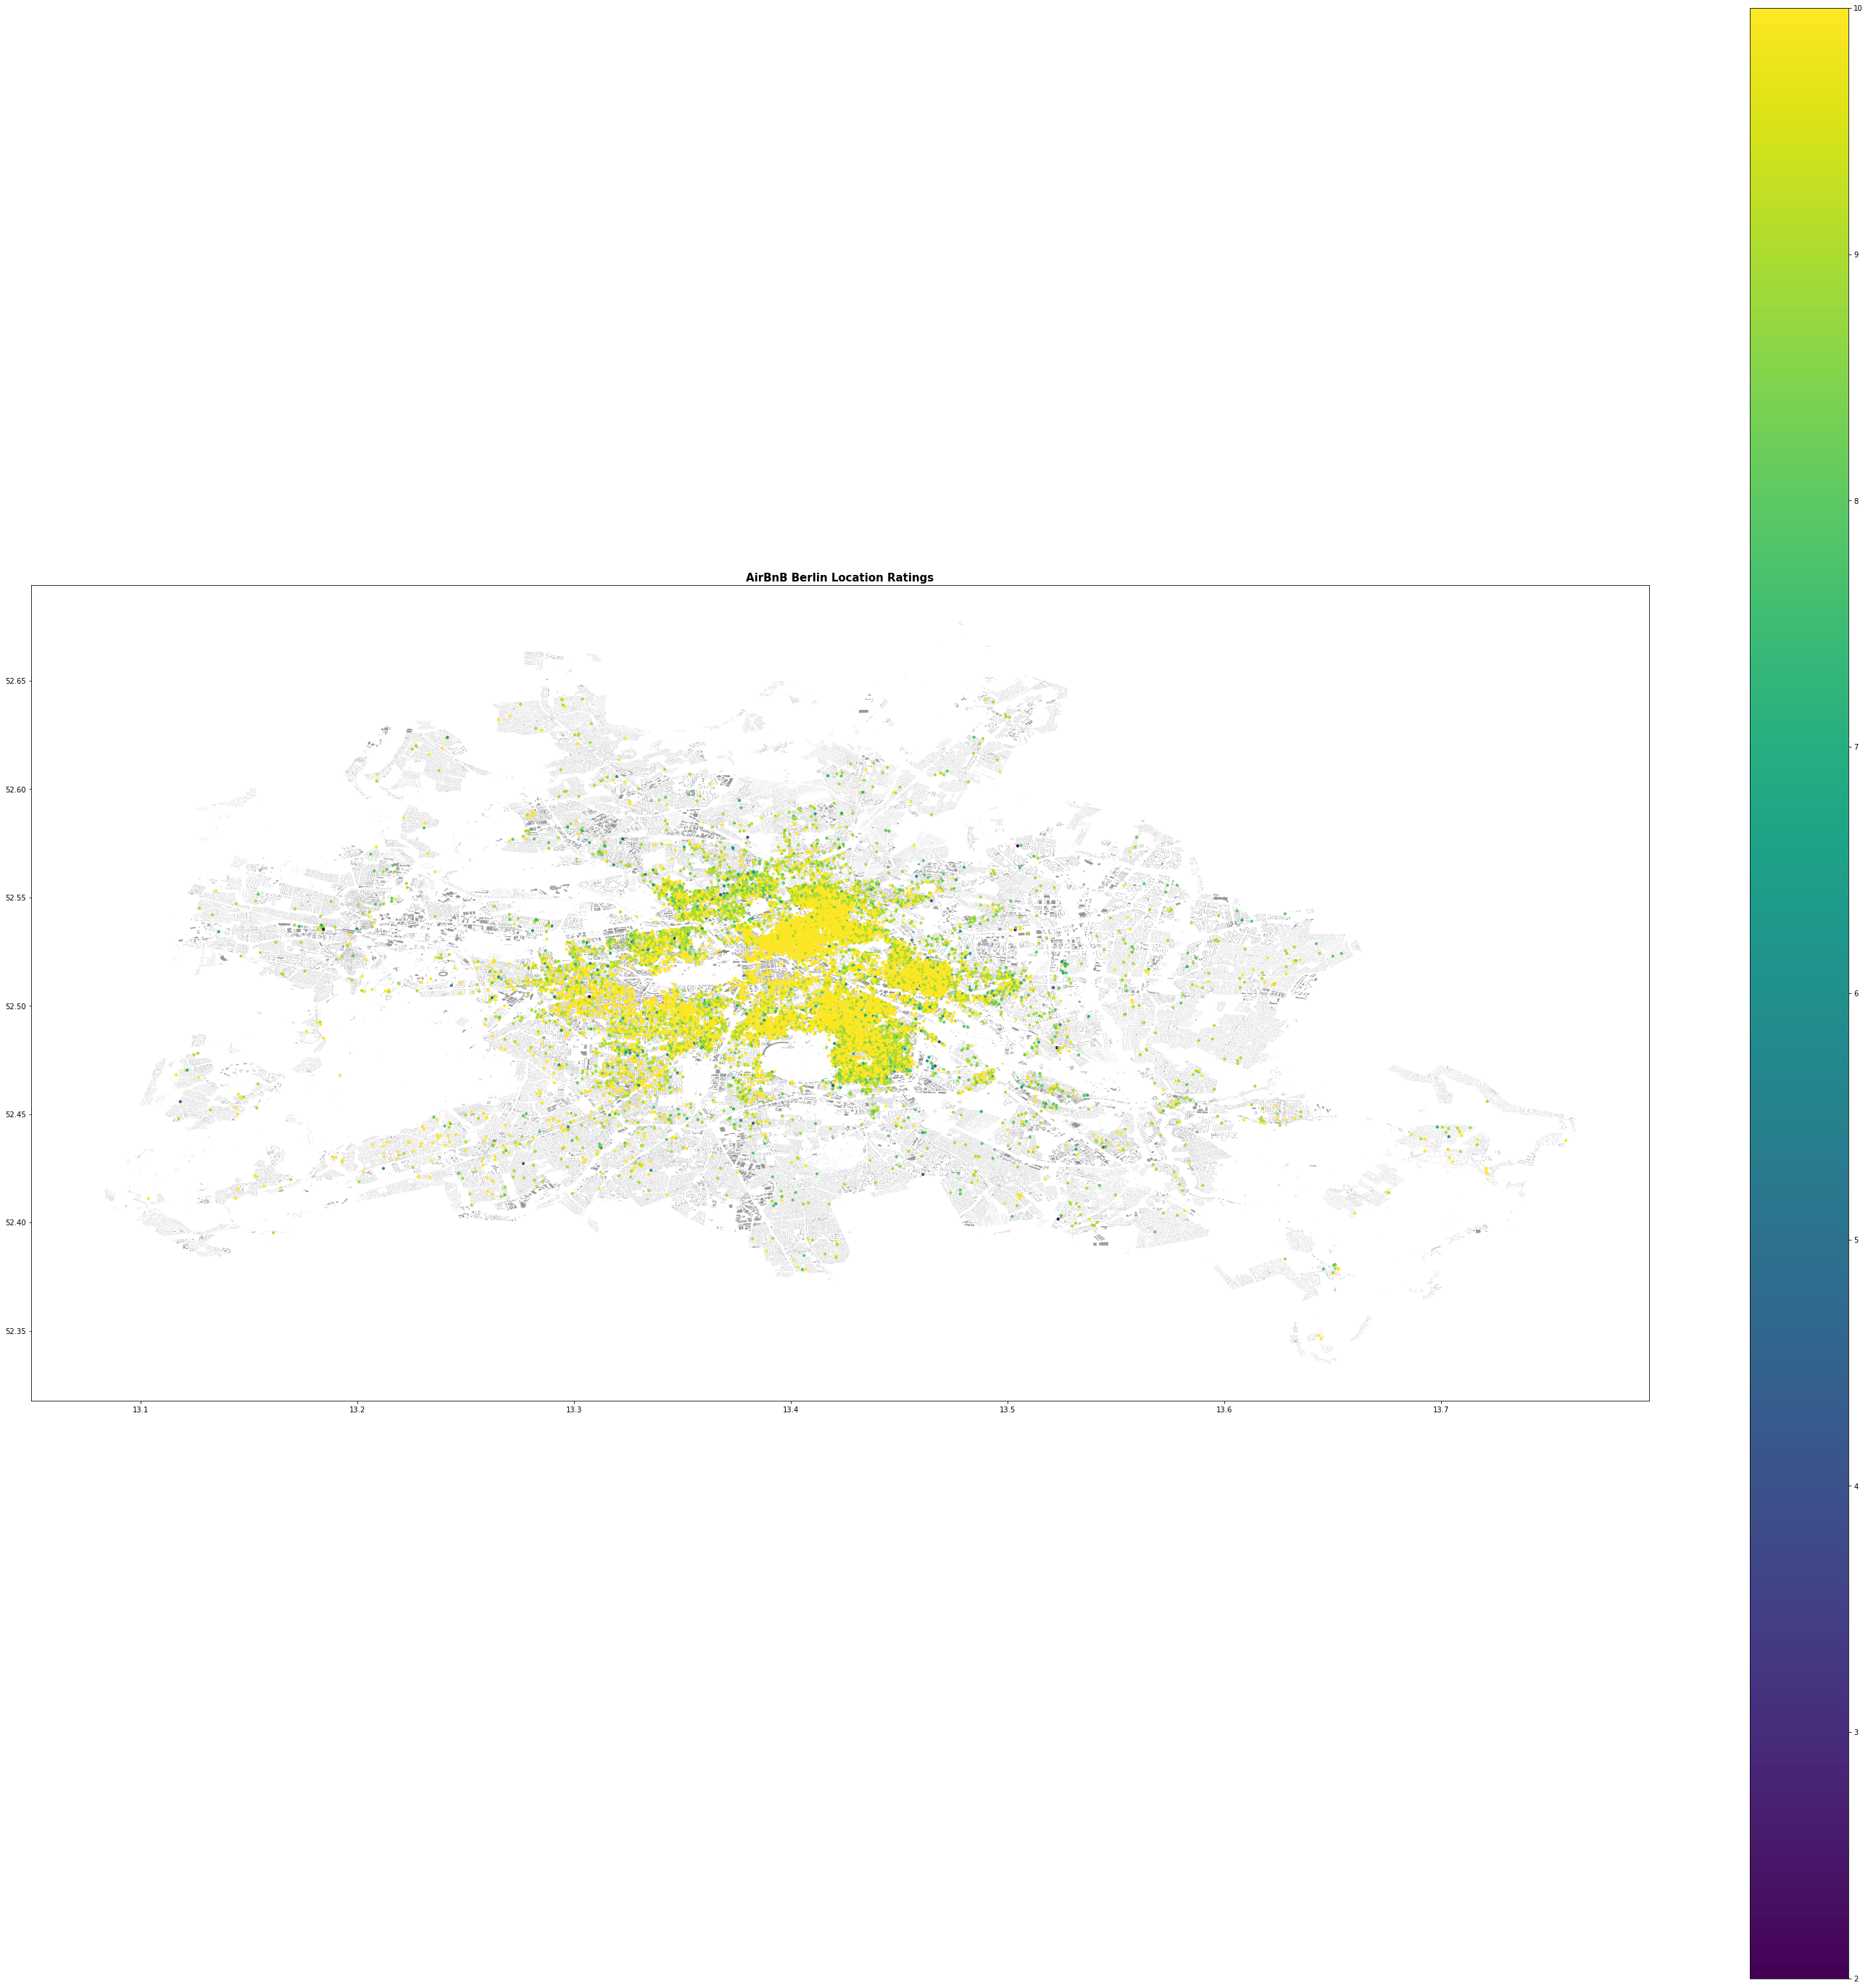

In [76]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20,20))

# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.8, color="grey")

# # add title to graph
plt.title("AirBnB Berlin Location Ratings", fontsize=15,fontweight="bold")

# # set latitiude and longitude boundaries for map display
# plt.xlim(52.2,52.8)
# plt.ylim(13,13.8)


# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column="review_scores_location", ax=ax, alpha=1, legend=True, markersize=10)



# # show map
plt.show()

In [77]:
df = run_query(
    """
    SELECT id, neighbourhood, neighbourhood_group_cleansed, review_scores_rating, review_scores_location, latitude, longitude, number_of_reviews
    FROM a_listings_summary
    WHERE neighbourhood_group_cleansed = "Mitte"
    """
)

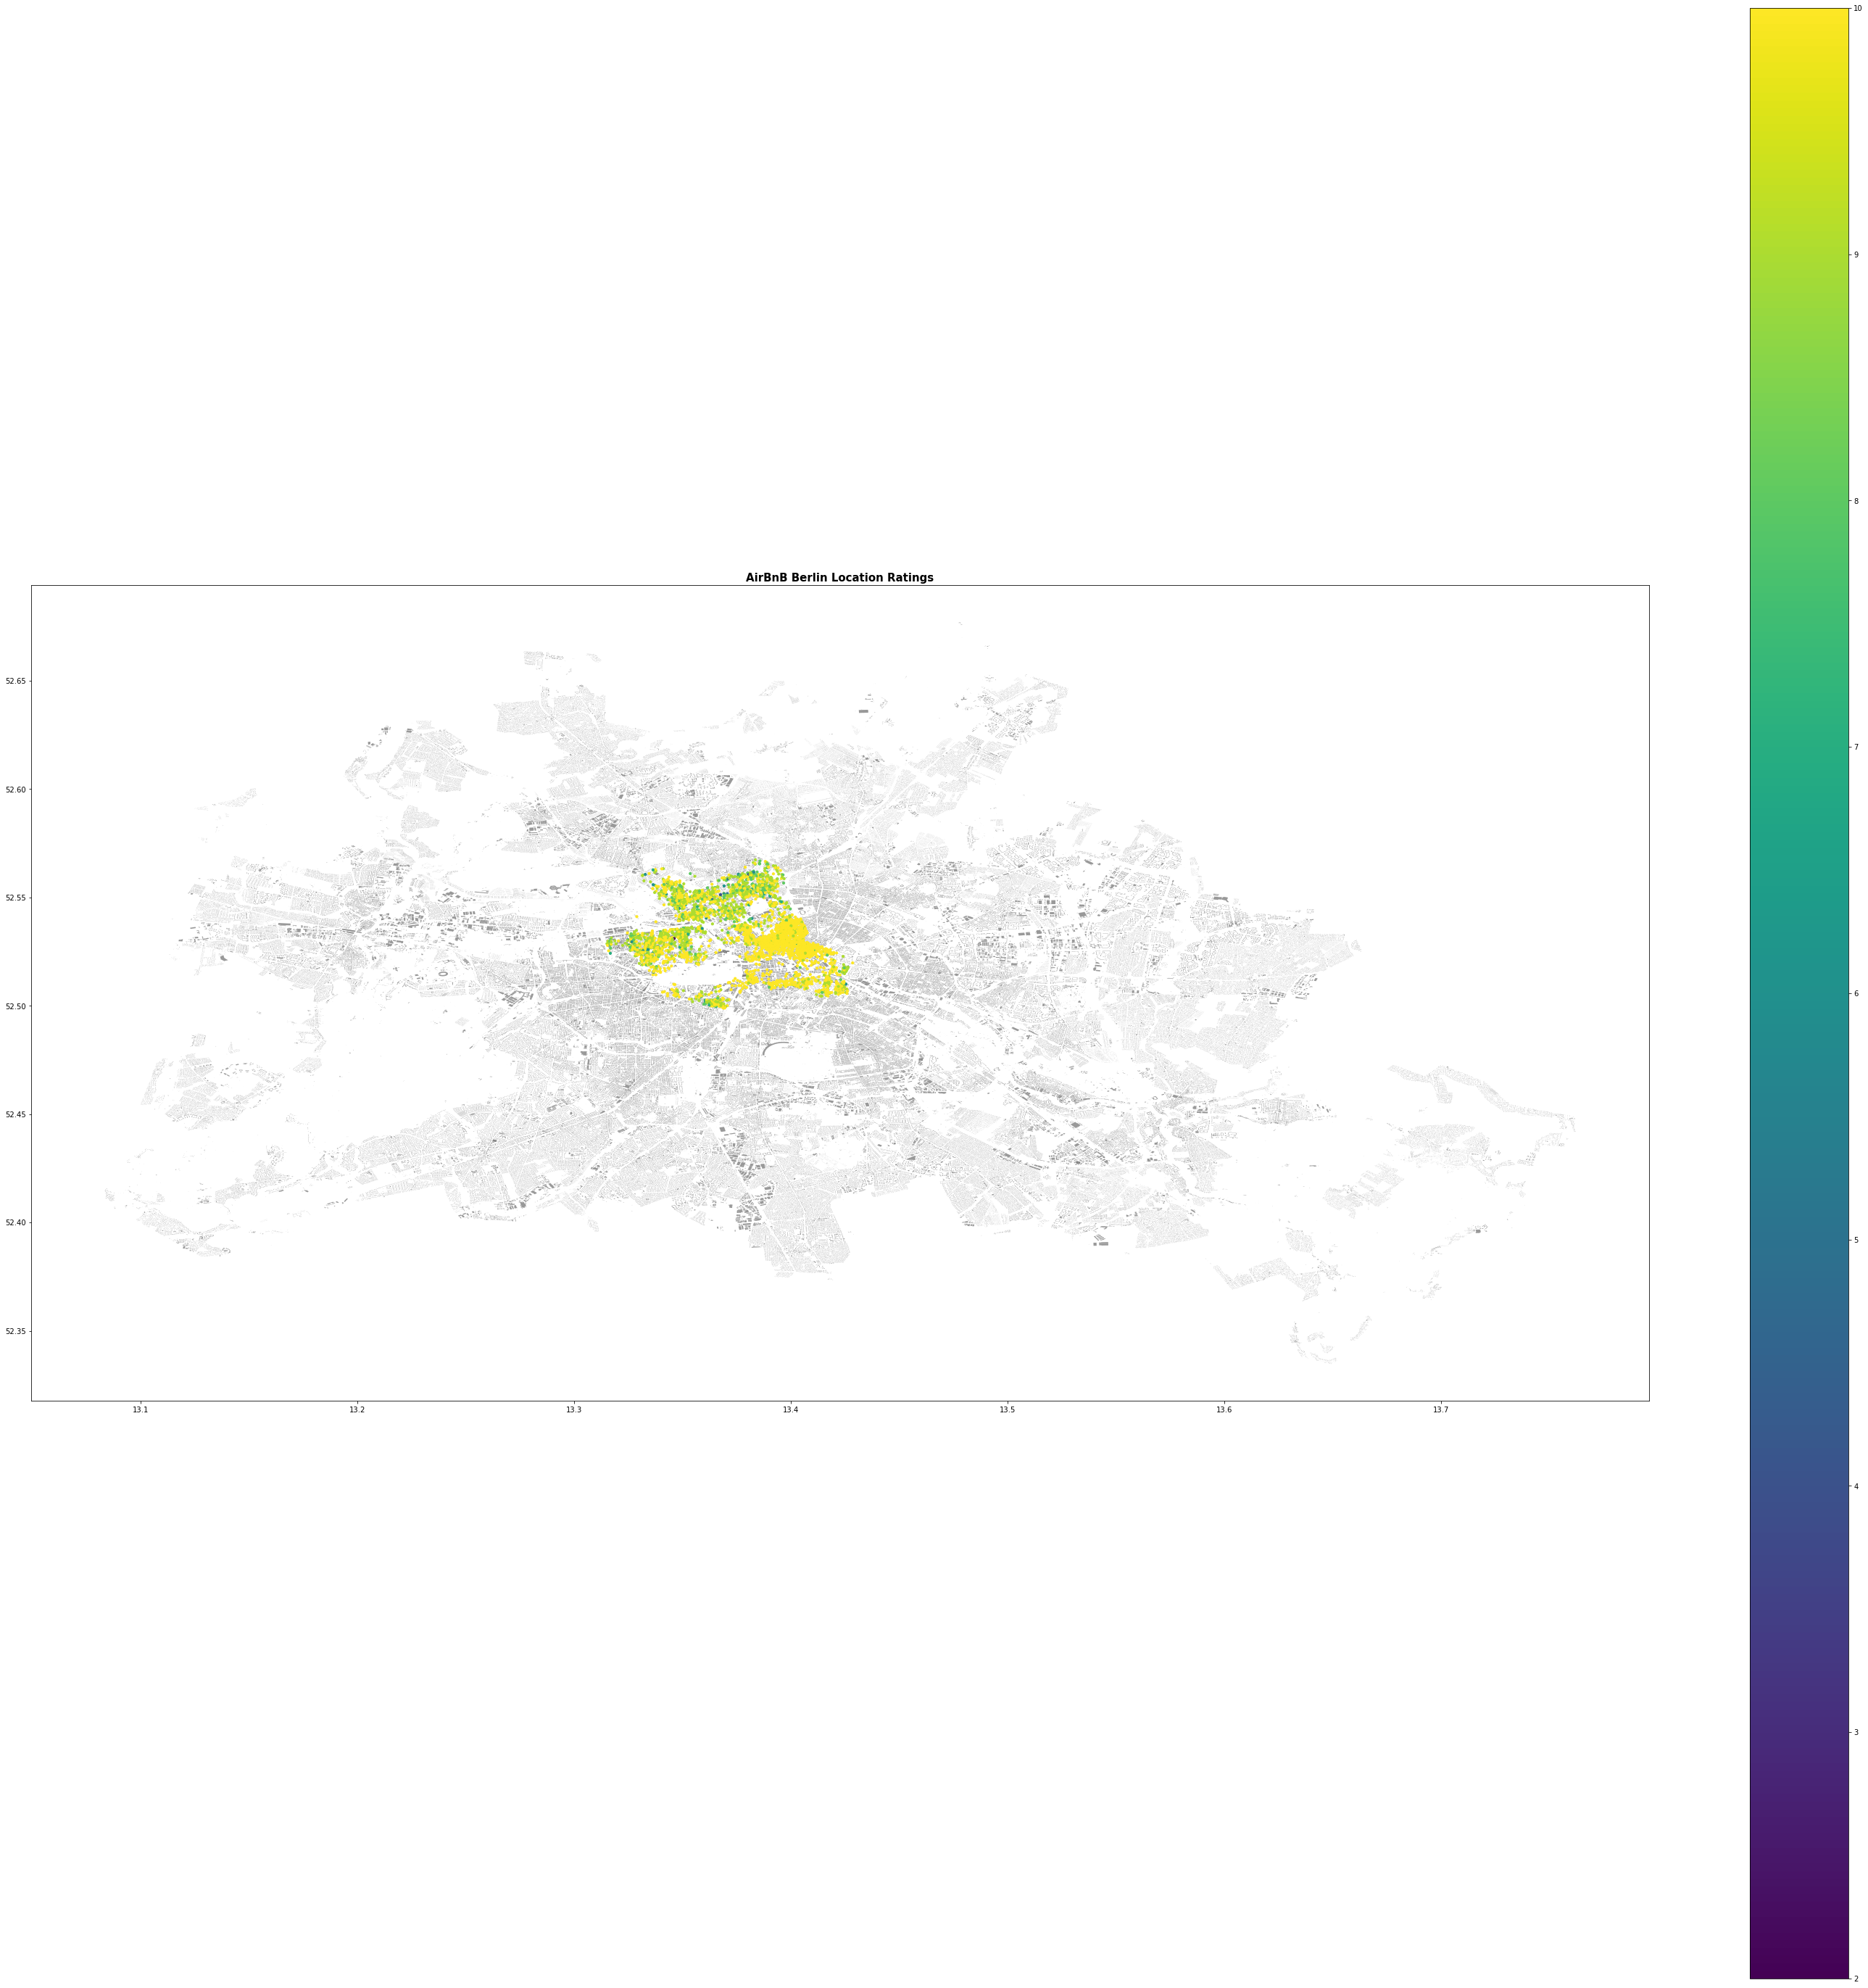

In [78]:
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df["longitude"],df["latitude"])]
       
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, geometry = geometry)

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20,20))

# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.8, color="grey")

# # add title to graph
plt.title("AirBnB Berlin Location Ratings", fontsize=15,fontweight="bold")

# # set latitiude and longitude boundaries for map display
# plt.xlim(52.2,52.8)
# plt.ylim(13,13.8)


# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column="review_scores_location", ax=ax, alpha=1, legend=True, markersize=10)

# # show map
plt.show()